In [ ]:
!pip uninstall -y protobuf
!pip install protobuf==3.20.3

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-qris/hasil_labeling.csv


In [2]:
!pip install nlpaug imbalanced-learn transformers -q

In [4]:
import os
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import json
import nltk
from collections import Counter

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_recall_fscore_support
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE

from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    set_seed as hf_set_seed
)

from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset


In [5]:
def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    hf_set_seed(seed)

set_all_seeds(42)
os.environ["WANDB_DISABLED"] = "true"

# from google.colab import drive
# drive.mount("/content/drive")

In [6]:
DATA_PATH = "/kaggle/input/dataset-qris/hasil_labeling.csv"
df = pd.read_csv(DATA_PATH)

assert "sentimen" in df.columns
assert "translated_text" in df.columns

df["translated_text"] = df["translated_text"].astype(str).fillna("")

le = LabelEncoder()
df["label"] = le.fit_transform(df["sentimen"])

print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
print("Distribusi awal label:", Counter(df["sentimen"]))

Label mapping: {'Negatif': 0, 'Netral': 1, 'Positif': 2}
Distribusi awal label: Counter({'Netral': 818, 'Positif': 399, 'Negatif': 212})


# **BERT**

In [7]:
# Plot distribusi label
def plot_distribution(before_counts, after_counts, title, filename):
    labels = list(before_counts.keys())
    before_vals = [before_counts[l] for l in labels]
    after_vals = [after_counts[l] for l in labels]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10,6))
    bars1 = ax.bar(x - width/2, before_vals, width, label='Before', color='#FFB6C1')
    bars2 = ax.bar(x + width/2, after_vals, width, label='After', color='skyblue')

    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    ax.set_title(title, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Grafik disimpan: {filename}")

# Dataset untuk BERT
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Trainer dengan class weights
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # # labels = inputs.get("labels").to(model.device)
        # outputs = model(**{k:v.to(model.device) for k,v in inputs.items() if k != "labels"})
        # logits = outputs.logits
        # loss_fct = CrossEntropyLoss(weight=self.class_weights)
        # loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        # return (loss, outputs) if return_outputs else loss

        device = next(model.parameters()).device

        labels = inputs["labels"].to(device)
        model_inputs = {k: v.to(device) for k, v in inputs.items() if k != "labels"}

        outputs = model(**model_inputs)
        logits = outputs.logits

        loss_fct = CrossEntropyLoss(weight=self.class_weights.to(device))
        loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

# Metrics BERT
def compute_metrics(eval_pred):
    preds = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

In [8]:
BASE_PATH = "/kaggle/working/results"
os.makedirs(f"{BASE_PATH}/bert_cv/models", exist_ok=True)
os.makedirs(f"{BASE_PATH}/bert_cv/preds", exist_ok=True)
os.makedirs(f"{BASE_PATH}/bert_cv/metrics", exist_ok=True)
os.makedirs(f"{BASE_PATH}/svm_cv/preds", exist_ok=True)
os.makedirs(f"{BASE_PATH}/svm_cv/metrics", exist_ok=True)
os.makedirs(f"{BASE_PATH}/svm_cv/models", exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)
else:
    print("Using CPU")

GPU name: Tesla P100-PCIE-16GB
CUDA version: 12.4


In [10]:
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)
syn_aug = naw.SynonymAug(aug_src="wordnet")
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
print("Augmenter & tokenizer siap")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Augmenter & tokenizer siap



========== BERT FOLD 1 ==========



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package ave

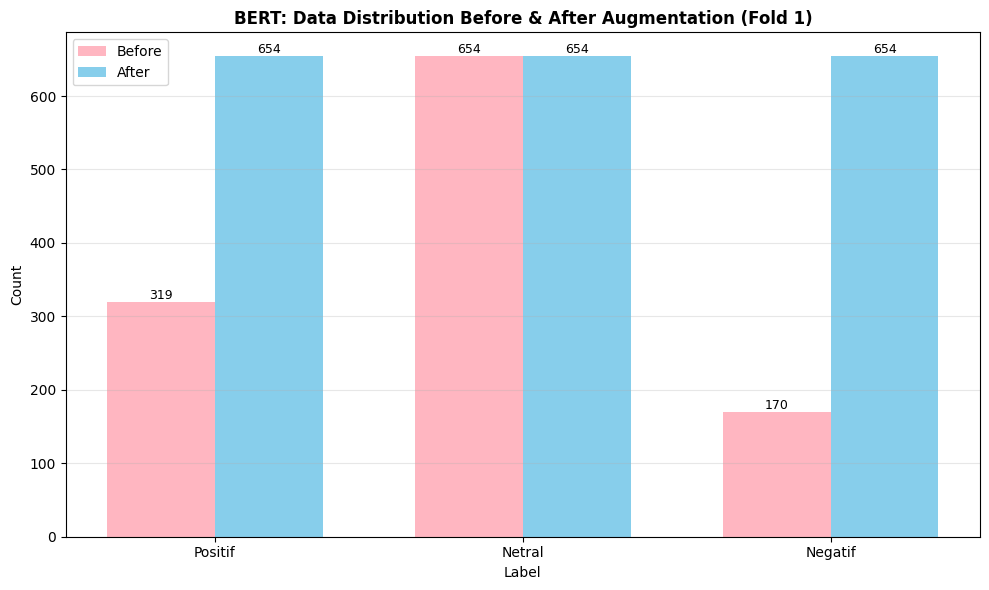

Grafik disimpan: /kaggle/working/results/bert_augmentation_distribution.png


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_216/3850150916.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


N_train = 1962
batch_size = 16
grad_accum = 1
expected steps/epoch = 123


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.652502,0.758741,0.790217,0.758741,0.764911
2,No log,0.546194,0.821678,0.830154,0.821678,0.824562
3,No log,0.656581,0.839161,0.849086,0.839161,0.841499



========== BERT FOLD 2 ==========



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package ave

N_train = 1962
batch_size = 16
grad_accum = 1
expected steps/epoch = 123


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.655563,0.737762,0.759839,0.737762,0.741905
2,No log,0.657071,0.807692,0.809723,0.807692,0.807946
3,No log,0.735062,0.825175,0.826180,0.825175,0.825468



========== BERT FOLD 3 ==========



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package ave

N_train = 1965
batch_size = 16
grad_accum = 1
expected steps/epoch = 123


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.552907,0.793706,0.806615,0.793706,0.797132
2,No log,0.532823,0.839161,0.845888,0.839161,0.841115
3,No log,0.541395,0.874126,0.876209,0.874126,0.874163



========== BERT FOLD 4 ==========



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package ave

N_train = 1965
batch_size = 16
grad_accum = 1
expected steps/epoch = 123


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.671700,0.748252,0.758769,0.748252,0.751128
2,No log,0.674107,0.814685,0.818770,0.814685,0.813163
3,No log,0.750285,0.821678,0.820568,0.821678,0.819978



========== BERT FOLD 5 ==========



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package ave

N_train = 1962
batch_size = 16
grad_accum = 1
expected steps/epoch = 123


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.509642,0.821053,0.821074,0.821053,0.821039
2,No log,0.441626,0.849123,0.849240,0.849123,0.846729
3,No log,0.480428,0.863158,0.863086,0.863158,0.862559



BERT 5-Fold CV Training selesai.



In [11]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

bert_acc, bert_prec, bert_rec, bert_f1 = [], [], [], []
all_y_true, all_y_pred = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(df["translated_text"], df["label"]), start=1):
    print(f"\n========== BERT FOLD {fold} ==========\n")

    # Split data
    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)

    # Augmentasi
    counts = Counter(train_df["label"])
    max_count = max(counts.values())
    aug_texts, aug_labels = [], []

    for lbl, cnt in counts.items():
        need = max_count - cnt
        if need <= 0: continue
        subset = train_df[train_df["label"]==lbl]["translated_text"].tolist()
        for _ in range(need):
            base = random.choice(subset)
            try: aug = syn_aug.augment(base)
            except: aug = base
            aug_texts.append(aug)
            aug_labels.append(lbl)

    aug_df = pd.DataFrame({"translated_text": aug_texts, "label": aug_labels})
    train_bal = pd.concat([train_df, aug_df], ignore_index=True)

    # Plot distribusi fold 1
    if fold == 1:
        plot_distribution(
            {le.inverse_transform([k])[0]: v for k,v in Counter(train_df["label"]).items()},
            {le.inverse_transform([k])[0]: v for k,v in Counter(train_bal["label"]).items()},
            "BERT: Data Distribution Before & After Augmentation (Fold 1)",
            f"{BASE_PATH}/bert_augmentation_distribution.png"
        )

    # Tokenisasi
    train_enc = tokenizer(train_bal["translated_text"].tolist(), truncation=True, padding="max_length", max_length=128)
    val_enc = tokenizer(val_df["translated_text"].tolist(), truncation=True, padding="max_length", max_length=128)

    train_ds = SentimentDataset(train_enc, train_bal["label"].tolist())
    val_ds = SentimentDataset(val_enc, val_df["label"].tolist())

    # Model
    num_labels = len(le.classes_)
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels).to(device)

    # Class weights
    cc = Counter(train_bal["label"])
    weights = torch.tensor([1.0 / cc.get(i,1) for i in range(num_labels)], dtype=torch.float).to(device)

    # Training arguments
    args = TrainingArguments(
        output_dir=f"{BASE_PATH}/bert_cv/models/fold_{fold}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        logging_dir=f"./logs/fold_{fold}",
        report_to="none"
    )

    trainer = WeightedTrainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        class_weights=weights,
        callbacks=[EarlyStoppingCallback(2)]
    )

    import math
    n = len(trainer.train_dataset)
    bs = trainer.args.per_device_train_batch_size
    gas = trainer.args.gradient_accumulation_steps

    print("N_train =", n)
    print("batch_size =", bs)
    print("grad_accum =", gas)
    print("expected steps/epoch =", math.ceil(n / (bs * gas)))

    # Train & Predict
    trainer.train()
    preds = trainer.predict(val_ds)
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)

    # Save
    pd.DataFrame({"original_index": val_idx, "y_true": y_true, "y_pred": y_pred}).to_csv(f"{BASE_PATH}/bert_cv/preds/fold_{fold}_preds.csv", index=False)
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)[0],
        "recall": precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)[1],
        "f1": precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)[2]
    }
    with open(f"{BASE_PATH}/bert_cv/metrics/fold_{fold}_metrics.json", "w") as f:
        json.dump(metrics, f, indent=2)

    # Aggregate
    bert_acc.append(metrics["accuracy"])
    bert_prec.append(metrics["precision"])
    bert_rec.append(metrics["recall"])
    bert_f1.append(metrics["f1"])
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)

print("\nBERT 5-Fold CV Training selesai.\n")


BERT AGGREGATE METRICS & CONFUSION MATRIX

Accuracy  : 0.8447 ± 0.0207
Precision : 0.8470 ± 0.0212
Recall    : 0.8447 ± 0.0207
F1-score  : 0.8447 ± 0.0209

Classification Report BERT (Aggregate):
              precision    recall  f1-score   support

     Negatif       0.70      0.72      0.71       212
      Netral       0.89      0.89      0.89       818
     Positif       0.82      0.81      0.82       399

    accuracy                           0.84      1429
   macro avg       0.81      0.81      0.81      1429
weighted avg       0.85      0.84      0.84      1429



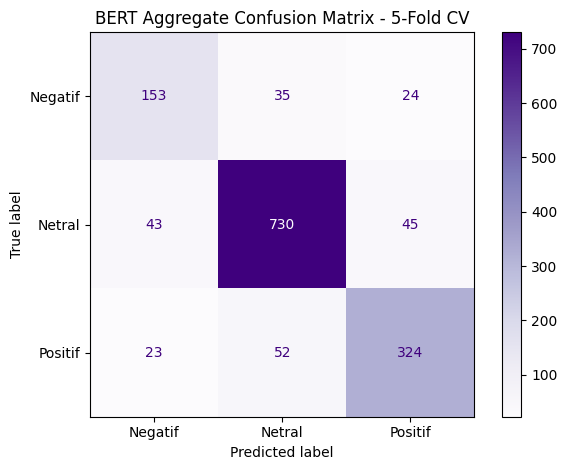

In [14]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print(f"\n{'='*60}")
print("BERT AGGREGATE METRICS & CONFUSION MATRIX")
print(f"{'='*60}\n")

# Aggregate metrics
print("Accuracy  : {:.4f} ± {:.4f}".format(np.mean(bert_acc), np.std(bert_acc)))
print("Precision : {:.4f} ± {:.4f}".format(np.mean(bert_prec), np.std(bert_prec)))
print("Recall    : {:.4f} ± {:.4f}".format(np.mean(bert_rec), np.std(bert_rec)))
print("F1-score  : {:.4f} ± {:.4f}".format(np.mean(bert_f1), np.std(bert_f1)))

# Classification report
print("\nClassification Report BERT (Aggregate):")
print(classification_report(all_y_true, all_y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Purples")
plt.title("BERT Aggregate Confusion Matrix - 5-Fold CV")
plt.tight_layout()
plt.savefig(f"{BASE_PATH}/bert_cv/aggregate_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()


# **SVM**


SVM 5-FOLD CROSS-VALIDATION


========== SVM FOLD 1 ==========



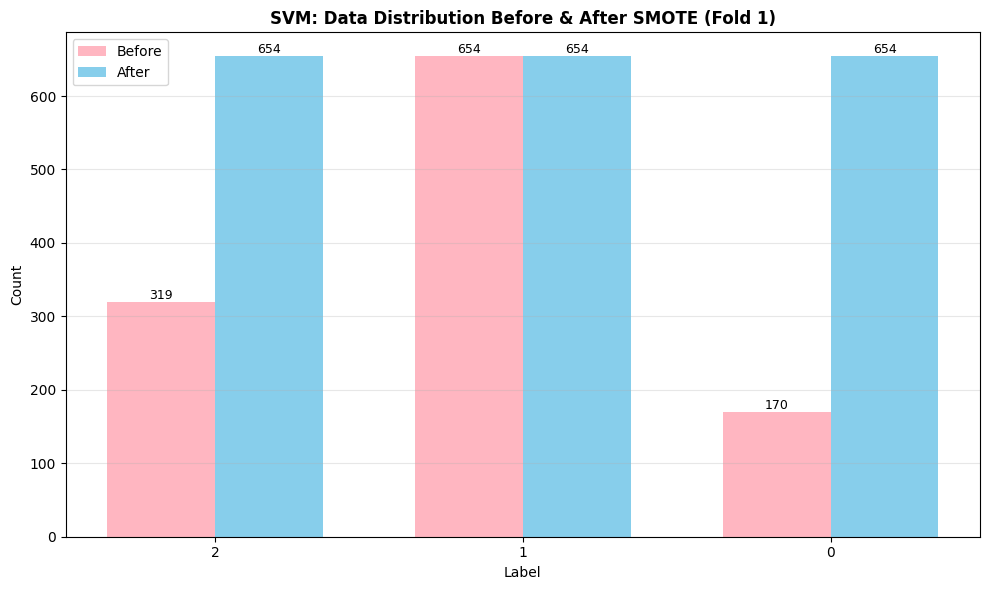

Grafik disimpan: /kaggle/working/results/svm_smote_distribution.png
Accuracy  : 0.8007
Precision : 0.7979
Recall    : 0.8007
F1-score  : 0.7984

========== SVM FOLD 2 ==========

Accuracy  : 0.7727
Precision : 0.7757
Recall    : 0.7727
F1-score  : 0.7737

========== SVM FOLD 3 ==========

Accuracy  : 0.8252
Precision : 0.8252
Recall    : 0.8252
F1-score  : 0.8245

========== SVM FOLD 4 ==========

Accuracy  : 0.8287
Precision : 0.8289
Recall    : 0.8287
F1-score  : 0.8241

========== SVM FOLD 5 ==========

Accuracy  : 0.7684
Precision : 0.7651
Recall    : 0.7684
F1-score  : 0.7657

SVM 5-Fold CV Training selesai.



In [15]:
print(f"\n{'='*60}")
print("SVM 5-FOLD CROSS-VALIDATION")
print(f"{'='*60}\n")

X = df["translated_text"].values
y = df["label"].values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_acc, svm_prec, svm_rec, svm_f1 = [], [], [], []
svm_y_true_all, svm_y_pred_all = [], []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
    print(f"\n========== SVM FOLD {fold} ==========\n")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # SMOTE
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

    # Plot distribusi fold 1
    if fold == 1:
        plot_distribution(
            dict(Counter(y_train)),
            dict(Counter(y_train_smote)),
            "SVM: Data Distribution Before & After SMOTE (Fold 1)",
            f"{BASE_PATH}/svm_smote_distribution.png"
        )

    # Train SVM
    model = LinearSVC(C=1.0, random_state=42, max_iter=2000)
    model.fit(X_train_smote, y_train_smote)

    # Predict
    y_pred = model.predict(X_test_tfidf)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted", zero_division=0)

    svm_acc.append(acc)
    svm_prec.append(prec)
    svm_rec.append(rec)
    svm_f1.append(f1)

    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1-score  : {f1:.4f}")

    # Save predictions
    pd.DataFrame({"original_index": test_idx, "y_true": y_test, "y_pred": y_pred}).to_csv(f"{BASE_PATH}/svm_cv/preds/fold_{fold}_preds.csv", index=False)
    pd.DataFrame({"accuracy":[acc], "precision":[prec], "recall":[rec], "f1":[f1]}).to_json(f"{BASE_PATH}/svm_cv/metrics/fold_{fold}_metrics.json", indent=2)

    svm_y_true_all.extend(y_test)
    svm_y_pred_all.extend(y_pred)

print("\nSVM 5-Fold CV Training selesai.\n")


SVM AGGREGATE METRICS & CONFUSION MATRIX

Accuracy  : 0.7991 ± 0.0253
Precision : 0.7986 ± 0.0256
Recall    : 0.7991 ± 0.0253
F1-score  : 0.7973 ± 0.0246

Classification Report SVM (Aggregate):
              precision    recall  f1-score   support

     Negatif       0.65      0.64      0.65       212
      Netral       0.84      0.89      0.86       818
     Positif       0.79      0.70      0.74       399

    accuracy                           0.80      1429
   macro avg       0.76      0.74      0.75      1429
weighted avg       0.80      0.80      0.80      1429



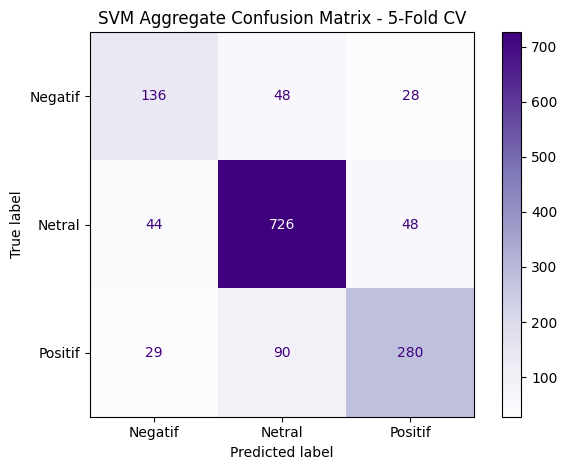

In [16]:
print(f"\n{'='*60}")
print("SVM AGGREGATE METRICS & CONFUSION MATRIX")
print(f"{'='*60}\n")

# Aggregate metrics
print("Accuracy  : {:.4f} ± {:.4f}".format(np.mean(svm_acc), np.std(svm_acc)))
print("Precision : {:.4f} ± {:.4f}".format(np.mean(svm_prec), np.std(svm_prec)))
print("Recall    : {:.4f} ± {:.4f}".format(np.mean(svm_rec), np.std(svm_rec)))
print("F1-score  : {:.4f} ± {:.4f}".format(np.mean(svm_f1), np.std(svm_f1)))

# Classification report
print("\nClassification Report SVM (Aggregate):")
print(classification_report(svm_y_true_all, svm_y_pred_all, target_names=le.classes_))

# Confusion matrix
cm_svm = confusion_matrix(svm_y_true_all, svm_y_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=le.classes_)
disp.plot(cmap="Purples")
plt.title("SVM Aggregate Confusion Matrix - 5-Fold CV")
plt.tight_layout()
plt.savefig(f"{BASE_PATH}/svm_cv/aggregate_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()


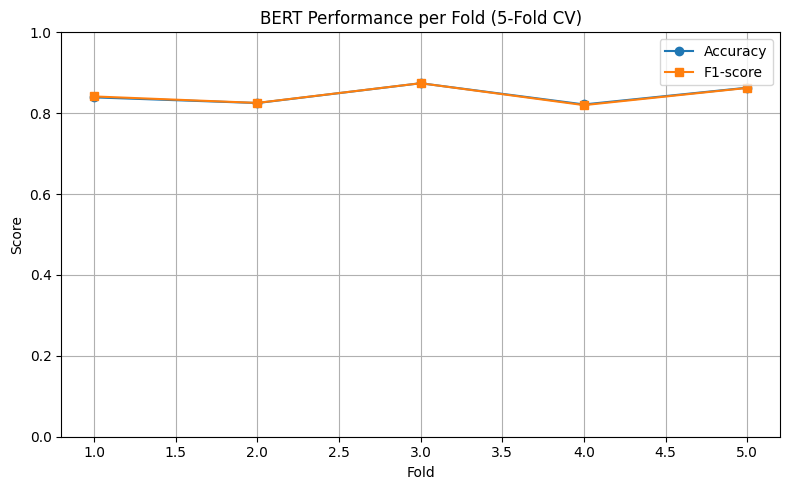

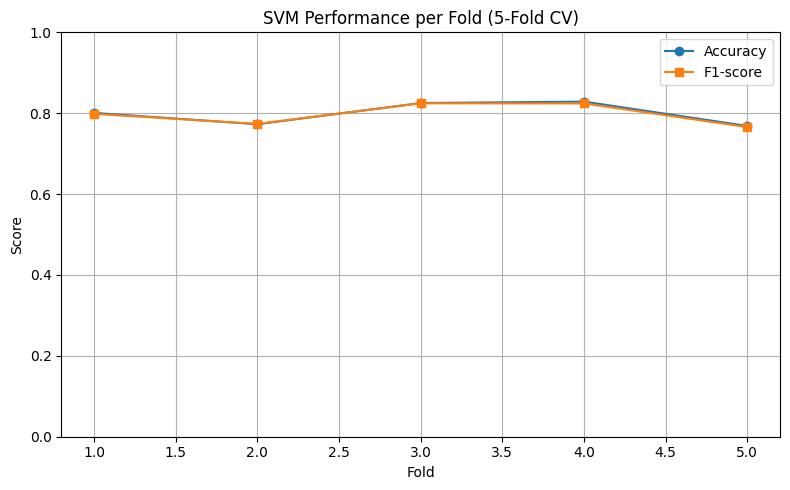

In [17]:
# Performance per Fold - BERT
plt.figure(figsize=(8,5))
plt.plot(range(1,6), bert_acc, marker='o', label="Accuracy")
plt.plot(range(1,6), bert_f1, marker='s', label="F1-score")
plt.title("BERT Performance per Fold (5-Fold CV)")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.ylim(0,1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{BASE_PATH}/bert_cv/performance_per_fold.png", dpi=300, bbox_inches='tight')
plt.show()

# Performance per Fold - SVM
plt.figure(figsize=(8,5))
plt.plot(range(1,6), svm_acc, marker='o', label="Accuracy")
plt.plot(range(1,6), svm_f1, marker='s', label="F1-score")
plt.title("SVM Performance per Fold (5-Fold CV)")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.ylim(0,1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{BASE_PATH}/svm_cv/performance_per_fold.png", dpi=300, bbox_inches='tight')
plt.show()

# **TES MC NEMAR**

In [18]:
print(f"\n{'='*60}")
print("MCNEMAR TEST: BERT vs SVM")
print(f"{'='*60}\n")

# Gabungkan semua prediksi dari semua fold
bert_preds_full = pd.concat([pd.read_csv(f"{BASE_PATH}/bert_cv/preds/fold_{f}_preds.csv") for f in range(1,6)]).sort_values("original_index").reset_index(drop=True)
svm_preds_full  = pd.concat([pd.read_csv(f"{BASE_PATH}/svm_cv/preds/fold_{f}_preds.csv") for f in range(1,6)]).sort_values("original_index").reset_index(drop=True)

y_true_mcnemar = bert_preds_full["y_true"].values
bert_pred_mcnemar = bert_preds_full["y_pred"].values
svm_pred_mcnemar = svm_preds_full["y_pred"].values

# Contingency table
n00 = np.sum((bert_pred_mcnemar==y_true_mcnemar)&(svm_pred_mcnemar==y_true_mcnemar))
n01 = np.sum((bert_pred_mcnemar==y_true_mcnemar)&(svm_pred_mcnemar!=y_true_mcnemar))
n10 = np.sum((bert_pred_mcnemar!=y_true_mcnemar)&(svm_pred_mcnemar==y_true_mcnemar))
n11 = np.sum((bert_pred_mcnemar!=y_true_mcnemar)&(svm_pred_mcnemar!=y_true_mcnemar))

print("McNemar Contingency Table:")
print(f"{'':20} | SVM Correct | SVM Wrong")
print(f"{'-'*50}")
print(f"{'BERT Correct':20} | {n00:11} | {n01:9}")
print(f"{'BERT Wrong':20} | {n10:11} | {n11:9}")

# McNemar statistic
from scipy.stats import chi2
mcnemar_stat = ((abs(n01 - n10)-1)**2)/(n01+n10) if (n01+n10)>0 else 0
p_value = 1 - chi2.cdf(mcnemar_stat, df=1)

print(f"\nMcNemar Statistic: {mcnemar_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print(" Hasil SIGNIFIKAN (p < 0.05)")
    print("  Ada perbedaan signifikan antara BERT dan SVM")
else:
    print(" Hasil TIDAK SIGNIFIKAN (p >= 0.05)")
    print("  Tidak ada perbedaan signifikan antara BERT dan SVM")

# Save results
mcnemar_results = {
    "contingency_table":{"bert_correct_svm_correct":int(n00),
                         "bert_correct_svm_wrong":int(n01),
                         "bert_wrong_svm_correct":int(n10),
                         "bert_wrong_svm_wrong":int(n11)},
    "mcnemar_statistic": float(mcnemar_stat),
    "p_value": float(p_value),
    "significant": bool(p_value<0.05)
}
with open(f"{BASE_PATH}/mcnemar_test_results.json", "w") as f:
    json.dump(mcnemar_results, f, indent=2)



MCNEMAR TEST: BERT vs SVM

McNemar Contingency Table:
                     | SVM Correct | SVM Wrong
--------------------------------------------------
BERT Correct         |        1035 |       172
BERT Wrong           |         107 |       115

McNemar Statistic: 14.6810
P-value: 0.0001
 Hasil SIGNIFIKAN (p < 0.05)
  Ada perbedaan signifikan antara BERT dan SVM


In [19]:
print(f"\n{'='*60}")
print("FINAL COMPARISON: BERT vs SVM")
print(f"{'='*60}\n")

comparison_df = pd.DataFrame({
    "Model":["BERT","SVM"],
    "Accuracy":[f"{np.mean(bert_acc):.4f} ± {np.std(bert_acc):.4f}",
                f"{np.mean(svm_acc):.4f} ± {np.std(svm_acc):.4f}"],
    "Precision":[f"{np.mean(bert_prec):.4f} ± {np.std(bert_prec):.4f}",
                 f"{np.mean(svm_prec):.4f} ± {np.std(svm_prec):.4f}"],
    "Recall":[f"{np.mean(bert_rec):.4f} ± {np.std(bert_rec):.4f}",
              f"{np.mean(svm_rec):.4f} ± {np.std(svm_rec):.4f}"],
    "F1-score":[f"{np.mean(bert_f1):.4f} ± {np.std(bert_f1):.4f}",
                f"{np.mean(svm_f1):.4f} ± {np.std(svm_f1):.4f}"]
})
print(comparison_df.to_string(index=False))
comparison_df.to_csv(f"{BASE_PATH}/model_comparison.csv", index=False)

print(f"\nSemua hasil tersimpan di folder: {BASE_PATH}")


FINAL COMPARISON: BERT vs SVM

Model        Accuracy       Precision          Recall        F1-score
 BERT 0.8447 ± 0.0207 0.8470 ± 0.0212 0.8447 ± 0.0207 0.8447 ± 0.0209
  SVM 0.7991 ± 0.0253 0.7986 ± 0.0256 0.7991 ± 0.0253 0.7973 ± 0.0246

Semua hasil tersimpan di folder: /kaggle/working/results


In [ ]:
display(comparison_df)